In [1]:
print("Namah Shivaya")

Namah Shivaya


In [2]:
# ✅ STEP 2: Mount Google Drive (Optional)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ✅ STEP 3: Copy Your Master Table (Assumes it's saved in Drive)
!cp /content/drive/MyDrive/grand_table.csv grand_table.csv

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("grand_table.csv")

In [6]:
grand_table = pd.read_csv("grand_table.csv")

In [7]:
df

,Ticker,Price,PE_Ratio,PB_Ratio,12M,18M,24M,36M,48M,60M,Momentum Score,average_cagr
0,RELIANCE,1392,23.0,3.2,19.0,18.5,18.0,17.5,17.0,16.5,84,17.8
1,TCS,3136,23.0,11.5,17.0,18.0,18.5,19.0,19.5,20.0,80,18.7
2,INFY,1516,24.3,7.1,17.0,18.0,18.5,19.0,19.5,20.0,82,18.7
3,HDFCBANK,2005,21.8,2.9,21.0,20.0,19.0,18.0,17.0,16.0,75,18.5
4,ICICIBANK,1477,20.0,3.2,16.5,16.0,15.5,15.0,14.5,14.0,70,15.3
5,ITC,409,14.8,7.3,18.0,18.5,19.0,19.5,20.0,20.5,86,19.3
6,LT,3443,21.0,4.2,10.0,12.0,13.0,15.0,16.0,18.0,78,14.0
7,SBIN,807,13.0,1.6,24.0,23.0,22.0,21.0,20.0,19.0,65,21.5
8,AXISBANK,1086,16.0,2.0,20.0,19.0,18.0,17.0,16.0,15.0,68,17.5
9,HINDUNILVR,2415,53.3,11.2,14.0,14.2,14.5,15.0,15.5,16.0,85,14.9


In [8]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings

# ===============================
# CONFIGURATION & WARNING SUPPRESSION
# ===============================

# Suppress matplotlib font warnings for emojis in Google Colab
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
warnings.filterwarnings('ignore', category=UserWarning, module='IPython')
warnings.filterwarnings("ignore", category=UserWarning, message="Glyph .* missing from font")

FORECAST_MAP = {
    12: "12M", 18: "18M", 24: "24M", 36: "36M", 48: "48M", 60: "60M",
}

# Set style for better visuals
plt.style.use('default')
sns.set_palette("husl")

# ===============================
# 1. STOCK SELECTION MODULE (Enhanced with Sector Diversification)
# ===============================

def get_forecast_column(horizon_months):
    return FORECAST_MAP.get(horizon_months, "60M")

def stock_selector(df, expected_cagr, horizon_months):
    forecast_col = get_forecast_column(horizon_months)

    if 'Volatility' not in df.columns:
        df['Volatility'] = 1 / (df['PE_Ratio'] + 0.1) + (100 - df['Momentum Score']) / 100

    df = df[df['average_cagr'] > 0.14].copy()

    df['PEG'] = df['PE_Ratio'] / (df['average_cagr'] * 100 + 1e-6)
    df['peg_adj_return'] = df[forecast_col] * np.exp(-0.5 * df['PEG'])
    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['PEG', 'peg_adj_return'])

    filtered = df[
        (df["PE_Ratio"] > 0) & (df["PE_Ratio"] <= 40) &
        (df["PB_Ratio"] > 0) & (df["PB_Ratio"] <= 10) &
        (df["Momentum Score"] >= 70) &
        #(df["ROE (%)"] >= 15) &
        (df[forecast_col] >= 0.14)
    ].copy()

    filtered = filtered.dropna(subset=[forecast_col, 'Volatility'])
    filtered = filtered.sort_values(by='peg_adj_return', ascending=False)

    selected_stocks = []
    cumulative_cagr = 0
    count = 0
    sector_counts = defaultdict(int)

    for _, row in filtered.iterrows():
        stock_cagr = row[forecast_col]
        sector = row.get("Sector", "Unknown")
        if sector_counts[sector] >= 2 and count >= 6:
            continue
        cumulative_cagr = ((cumulative_cagr * count) + stock_cagr) / (count + 1)
        selected_stocks.append(row)
        sector_counts[sector] += 1
        count += 1
        if cumulative_cagr >= expected_cagr and count >= 6:
            break

    feasible = cumulative_cagr >= expected_cagr

    if not feasible:
        fallback_stocks = filtered.head(8)
        fallback_cagr = fallback_stocks[forecast_col].mean()
        return fallback_stocks.reset_index(drop=True), False, fallback_cagr
    else:
        selected_df = pd.DataFrame(selected_stocks).reset_index(drop=True)
        return selected_df, True, cumulative_cagr

# ===============================
# 2. OPTIMIZATION MODULE (MPT)
# ===============================

def optimize_portfolio(selected_df, horizon_months):
    forecast_col = get_forecast_column(horizon_months)
    returns = selected_df[forecast_col].values
    risks = selected_df["Volatility"].values
    cov_matrix = np.diag(risks ** 2)

    def objective(weights):
        port_return = np.dot(weights, returns)
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -port_return / port_vol

    n = len(returns)
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = [(0, 1)] * n
    init_guess = np.ones(n) / n

    result = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        selected_df['Weight'] = result.x
    else:
        selected_df['Weight'] = 1.0 / n

    return selected_df

# ===============================
# 3. FINAL PROJECTION & METRICS
# ===============================

def compute_projection(df, monthly_investment, horizon_months, horizon_cagr):
    monthly_cagr = horizon_cagr / 100 / 12
    total_investment = monthly_investment * horizon_months
    if monthly_cagr > 0:
        future_value = monthly_investment * (((1 + monthly_cagr) ** horizon_months - 1) / monthly_cagr)
    else:
        future_value = total_investment
    gain = future_value - total_investment
    return round(total_investment), round(future_value), round(gain)

# ===============================
# 4. ENHANCED VISUALIZATION MODULE
# ===============================

def plot_enhanced_projection(monthly_investment, horizon_months, achieved_cagr, optimized_df=None):
    """
    Creates comprehensive investment visualization with multiple subplots
    """
    fig = plt.figure(figsize=(16, 12))

    # Calculate projections for the specified horizon
    months = np.arange(1, horizon_months + 1)
    monthly_cagr = achieved_cagr / 100 / 12  # Convert annual to monthly

    # Calculate cumulative investment (linear)
    cumulative_invested = monthly_investment * months

    # Calculate projected value using monthly compounding
    projected_values = []
    for month in months:
        if monthly_cagr > 0:
            fv = monthly_investment * (((1 + monthly_cagr) ** month - 1) / monthly_cagr)
        else:
            fv = monthly_investment * month
        projected_values.append(fv)

    projected_values = np.array(projected_values)
    gains = projected_values - cumulative_invested

    # Subplot 1: Main Investment Growth Chart
    ax1 = plt.subplot(2, 3, (1, 2))
    ax1.fill_between(months, cumulative_invested, projected_values,
                     alpha=0.3, color='green', label='Potential Gains')
    ax1.plot(months, cumulative_invested, '--', linewidth=3, color='#2E86AB',
             label='Total Investment', marker='o', markersize=3, markevery=12)
    ax1.plot(months, projected_values, '-', linewidth=3, color='#A23B72',
             label=f'Portfolio Value ({achieved_cagr:.1f}% CAGR)', marker='s', markersize=4, markevery=12)

    key_months = [m for m in [12, 24, 36, 48, 60] if m <= horizon_months]
    for month in key_months:
        idx = month - 1
        ax1.annotate(f'₹{projected_values[idx]/100000:.1f}L',
                    xy=(month, projected_values[idx]),
                    xytext=(month, projected_values[idx] + max(projected_values)*0.08),
                    ha='center', fontsize=10, fontweight='bold',
                    arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

    ax1.set_xlabel('Investment Period (Months)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Amount (₹)', fontsize=12, fontweight='bold')
    ax1.set_title(f'💰 Your Investment Journey: ₹{monthly_investment:,}/month for {horizon_months} months',
                  fontsize=14, fontweight='bold', pad=20)
    ax1.legend(loc='upper left', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.ticklabel_format(style='plain', axis='y')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'₹{x/100000:.1f}L' if x >= 100000 else f'₹{x/1000:.0f}K'))

    # Subplot 2: Year-on-Year Growth
    ax2 = plt.subplot(2, 3, 3)
    years = list(range(1, int(horizon_months / 12) + 1))
    year_months = [m for m in [12, 24, 36, 48, 60] if m <= horizon_months]
    year_invested = [cumulative_invested[m-1] for m in year_months]
    year_projected = [projected_values[m-1] for m in year_months]
    year_gains = [year_projected[i] - year_invested[i] for i in range(len(years))]

    x_pos = np.arange(len(years))
    width = 0.35
    bars1 = ax2.bar(x_pos - width/2, [v/100000 for v in year_invested], width,
                    label='Invested', color='#2E86AB', alpha=0.8)
    bars2 = ax2.bar(x_pos + width/2, [v/100000 for v in year_gains], width,
                    label='Gains', color='#F18F01', alpha=0.8)

    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        ax2.text(bar1.get_x() + bar1.get_width()/2., height1 + 0.1,
                f'₹{height1:.1f}L', ha='center', va='bottom', fontsize=9, fontweight='bold')
        ax2.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.1,
                f'₹{height2:.1f}L', ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Amount (₹ Lakhs)', fontsize=12, fontweight='bold')
    ax2.set_title('📈 Year-wise Breakdown', fontsize=12, fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f'Year {y}' for y in years])
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')

    # Subplot 3: Portfolio Allocation (if provided)
    if optimized_df is not None and len(optimized_df) > 0:
        ax3 = plt.subplot(2, 3, 4)
        top_holdings = optimized_df.nlargest(8, 'Weight')
        others_weight = optimized_df[~optimized_df.index.isin(top_holdings.index)]['Weight'].sum()

        if others_weight > 0:
            plot_data = pd.concat([top_holdings, pd.DataFrame({
                'Ticker': ['Others'], 'Weight': [others_weight]
            })], ignore_index=True)
        else:
            plot_data = top_holdings

        colors = plt.cm.Set3(np.linspace(0, 1, len(plot_data)))
        wedges, texts, autotexts = ax3.pie(plot_data['Weight'], labels=plot_data['Ticker'],
                                          autopct='%1.1f%%', colors=colors, startangle=90)

        ax3.set_title('🎯 Portfolio Allocation', fontsize=12, fontweight='bold')

        for autotext in autotexts:
            autotext.set_weight('bold')
            autotext.set_fontsize(9)

    # Subplot 4: Monthly Investment Breakdown
    ax4 = plt.subplot(2, 3, 5)
    if optimized_df is not None and len(optimized_df) > 0:
        monthly_allocations = optimized_df['Monthly Allocation (INR)'].head(8)
        stock_names = optimized_df['Ticker'].head(8)

        bars = ax4.barh(range(len(monthly_allocations)), monthly_allocations,
                       color=plt.cm.magma(np.linspace(0, 0.8, len(monthly_allocations))),
                       edgecolor='gray', alpha=0.9, linewidth=0.5)

        ax4.set_yticks(range(len(monthly_allocations)))
        ax4.set_yticklabels(stock_names, fontsize=10, fontweight='bold', rotation=15)
        ax4.set_xlabel('Monthly Investment (₹)', fontsize=12, fontweight='bold')
        ax4.set_title('💸 Monthly Stock Allocation', fontsize=14, fontweight='bold', pad=10)

        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax4.text(width + max(monthly_allocations)*0.01, bar.get_y() + bar.get_height()/2,
                    f'₹{width:,.0f}', ha='left', va='center', fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray'))

        ax4.tick_params(axis='x', labelsize=10, labelcolor='black', width=1.5)
        ax4.grid(axis='x', linestyle='--', alpha=0.2, color='gray')
        ax4.set_xlim(0, max(monthly_allocations) * 1.2)

    # Subplot 5: Key Metrics Summary
    ax5 = plt.subplot(2, 3, 6)  # Define ax5 here
    ax5.axis('off')

    # Calculate final values
    final_invested = cumulative_invested[horizon_months-1]
    final_value = projected_values[horizon_months-1]
    total_gain = final_value - final_invested
    gain_percentage = (total_gain / final_invested) * 100

    # Create summary text
    summary_text = f"""
    📊 INVESTMENT SUMMARY

    🎯 Target Period: {horizon_months} months ({horizon_months/12:.1f} years)
    💰 Monthly Investment: ₹{monthly_investment:,}
    📈 Expected CAGR: {achieved_cagr:.2f}%

    💵 Total Investment: ₹{final_invested:,.0f}
    🚀 Final Portfolio Value: ₹{final_value:,.0f}
    💎 Total Gains: ₹{total_gain:,.0f}
    📊 Total Return: {gain_percentage:.1f}%

    🎉 Your money grows by {final_value/final_invested:.1f}x!
    """

    ax5.text(0.1, 0.9, summary_text, transform=ax5.transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5",
             facecolor="lightblue", alpha=0.8), fontweight='bold')

    plt.tight_layout(pad=3.0)
    plt.suptitle(f'🌟 VRIDDHI INVESTMENT PLAN - Complete Analysis 🌟',
                 fontsize=16, fontweight='bold', y=0.98)
    plt.show()

# ===============================
# 4. FINAL OUTPUT MODULE (Updated with Frill Integration)
# ===============================

def final_summary_output(feasible: bool, horizon_months: int, expected_cagr: float, achieved_cagr: float, projected_value: float, total_invested: float, best_horizon_60_cagr: float, max_possible_cagr_current_horizon: float, frill_output: dict):
    horizon_years = horizon_months / 12
    gain = projected_value - total_invested

    print("="*80)
    print("🎯 VRIDDHI INVESTMENT ANALYSIS REPORT")
    print("="*80)

    # Display the technical frill output first
    print("🔢 TECHNICAL SUMMARY:")
    print(f"   Feasible: {frill_output['Feasible']}")
    print(f"   Expected CAGR: {frill_output['Expected CAGR']:.2f}%")
    #print(f"   Achieved CAGR: {frill_output['Achieved CAGR']:.4f}%")
    print(f"   Achieved CAGR: {frill_output['Achieved CAGR']:.2f}%")
    print(f"   Final Value: ₹{frill_output['Final Value']:,}")
    print(f"   Total Gain: ₹{frill_output['Gain']:,}\n")

    if feasible:
        print("🎉 SUCCESS: Your investment goals are ACHIEVABLE! 🎉\n")
        print(f"📋 PLAN SUMMARY:")
        print(f"   • Investment Period: {horizon_years:.1f} years ({horizon_months} months)")
        print(f"   • Total Investment: ₹{int(total_invested):,}")
        print(f"   • Expected CAGR: {expected_cagr:.2f}% → Achieved CAGR: {achieved_cagr:.2f}%")
        print(f"   • Final Portfolio Value: ₹{int(projected_value):,}")
        print(f"   • Total Gains: ₹{int(gain):,}")
        print(f"   • Money Multiplier: {projected_value/total_invested:.2f}x\n")

        print("✨ WHAT THIS MEANS FOR YOU:")
        print(f"   Your disciplined investment will grow your wealth by ₹{int(gain):,}")
        print(f"   Every ₹1 you invest will become ₹{projected_value/total_invested:.2f}")
        print("   You're on the path to financial growth! 📈\n")

        print("🎊 CELEBRATION METRICS:")
        print(f"   • You'll be ₹{int(gain):,} richer!")
        print(f"   • That's ₹{int(gain/horizon_months):,} average gain per month!")
        print(f"   • Your wealth will grow {((projected_value/total_invested - 1) * 100):.1f}% over {horizon_years:.1f} years!")

    else:
        print("⚠️  REALITY CHECK: Your expectations need adjustment ⚠️\n")
        print(f"📋 CURRENT SCENARIO:")
        print(f"   • Desired CAGR: {expected_cagr:.2f}%")
        print(f"   • Best Achievable CAGR ({horizon_months} months): {max_possible_cagr_current_horizon:.2f}%")
        print(f"   • Gap: {expected_cagr - max_possible_cagr_current_horizon:.2f}% short\n")

        print("💰 BUT HERE'S THE GOOD NEWS:")
        print(f"   • Even at {achieved_cagr:.2f}% CAGR, you'll still gain ₹{int(gain):,}!")
        print(f"   • Your ₹{int(total_invested):,} will become ₹{int(projected_value):,}")
        print(f"   • That's still a {((projected_value/total_invested - 1) * 100):.1f}% total return!")
        print(f"   • Monthly average gain: ₹{int(gain/horizon_months):,}\n")

        print("💡 SMART RECOMMENDATIONS:")
        print(f"   • Option 1: Accept {max_possible_cagr_current_horizon:.2f}% CAGR → Gain ₹{int(gain):,}")
        print(f"   • Option 2: Extend to 60 months for up to {best_horizon_60_cagr:.2f}% CAGR")
        print(f"   • Option 3: Increase monthly investment to reach your target faster")
        print(f"   • Option 4: Adjust expectations - {achieved_cagr:.2f}% is still excellent!\n")

        print("🧠 PERSPECTIVE CHECK:")
        print(f"   • Bank FD gives ~7% → You're getting {achieved_cagr:.1f}%!")
        print(f"   • Inflation is ~6% → You're beating it by {achieved_cagr - 6:.1f}%!")
        print("   • This is solid wealth creation, even if not your original target!")

    print("="*80)

# ===============================
# 6. WRAPPER FUNCTION (Updated)
# ===============================

def run_vriddhi_backend(df, monthly_investment, expected_cagr, horizon_months):
    print("🚀 Starting Vriddhi Investment Analysis...\n")

    selected_df, feasible, achieved_cagr = stock_selector(df, expected_cagr, horizon_months)
    optimized_df = optimize_portfolio(selected_df, horizon_months)
    optimized_df["Monthly Allocation (INR)"] = optimized_df["Weight"] * monthly_investment

    total_invested, final_value, gain = compute_projection(
        optimized_df, monthly_investment, horizon_months, achieved_cagr
    )

    _, _, best_cagr_60 = stock_selector(df, expected_cagr, 60)

    # Create the frill output dictionary
    frill_output = {
        "Feasible": feasible,
        "Expected CAGR": expected_cagr,
        "Achieved CAGR": achieved_cagr,
        "Final Value": final_value,
        "Gain": gain
    }

    final_summary_output(
        feasible=feasible,
        horizon_months=horizon_months,
        expected_cagr=expected_cagr,
        achieved_cagr=achieved_cagr,
        projected_value=final_value,
        total_invested=total_invested,
        best_horizon_60_cagr=best_cagr_60,
        max_possible_cagr_current_horizon=achieved_cagr,
        frill_output=frill_output
    )

    # Enhanced visualization
    print("\n📊 Generating comprehensive investment visualization...\n")
    plot_enhanced_projection(monthly_investment, horizon_months, achieved_cagr, optimized_df)

    return optimized_df[['Ticker', 'Weight', 'Monthly Allocation (INR)']], frill_output

🚀 Starting Vriddhi Investment Analysis...

🎯 VRIDDHI INVESTMENT ANALYSIS REPORT
🔢 TECHNICAL SUMMARY:
   Feasible: False
   Expected CAGR: 25.00%
   Achieved CAGR: 19.06%
   Final Value: ₹4,955,629
   Total Gain: ₹1,955,629

⚠️  REALITY CHECK: Your expectations need adjustment ⚠️

📋 CURRENT SCENARIO:
   • Desired CAGR: 25.00%
   • Best Achievable CAGR (60 months): 19.06%
   • Gap: 5.94% short

💰 BUT HERE'S THE GOOD NEWS:
   • Even at 19.06% CAGR, you'll still gain ₹1,955,629!
   • Your ₹3,000,000 will become ₹4,955,629
   • That's still a 65.2% total return!
   • Monthly average gain: ₹32,593

💡 SMART RECOMMENDATIONS:
   • Option 1: Accept 19.06% CAGR → Gain ₹1,955,629
   • Option 2: Extend to 60 months for up to 19.06% CAGR
   • Option 3: Increase monthly investment to reach your target faster
   • Option 4: Adjust expectations - 19.06% is still excellent!

🧠 PERSPECTIVE CHECK:
   • Bank FD gives ~7% → You're getting 19.1%!
   • Inflation is ~6% → You're beating it by 13.1%!
   • This 

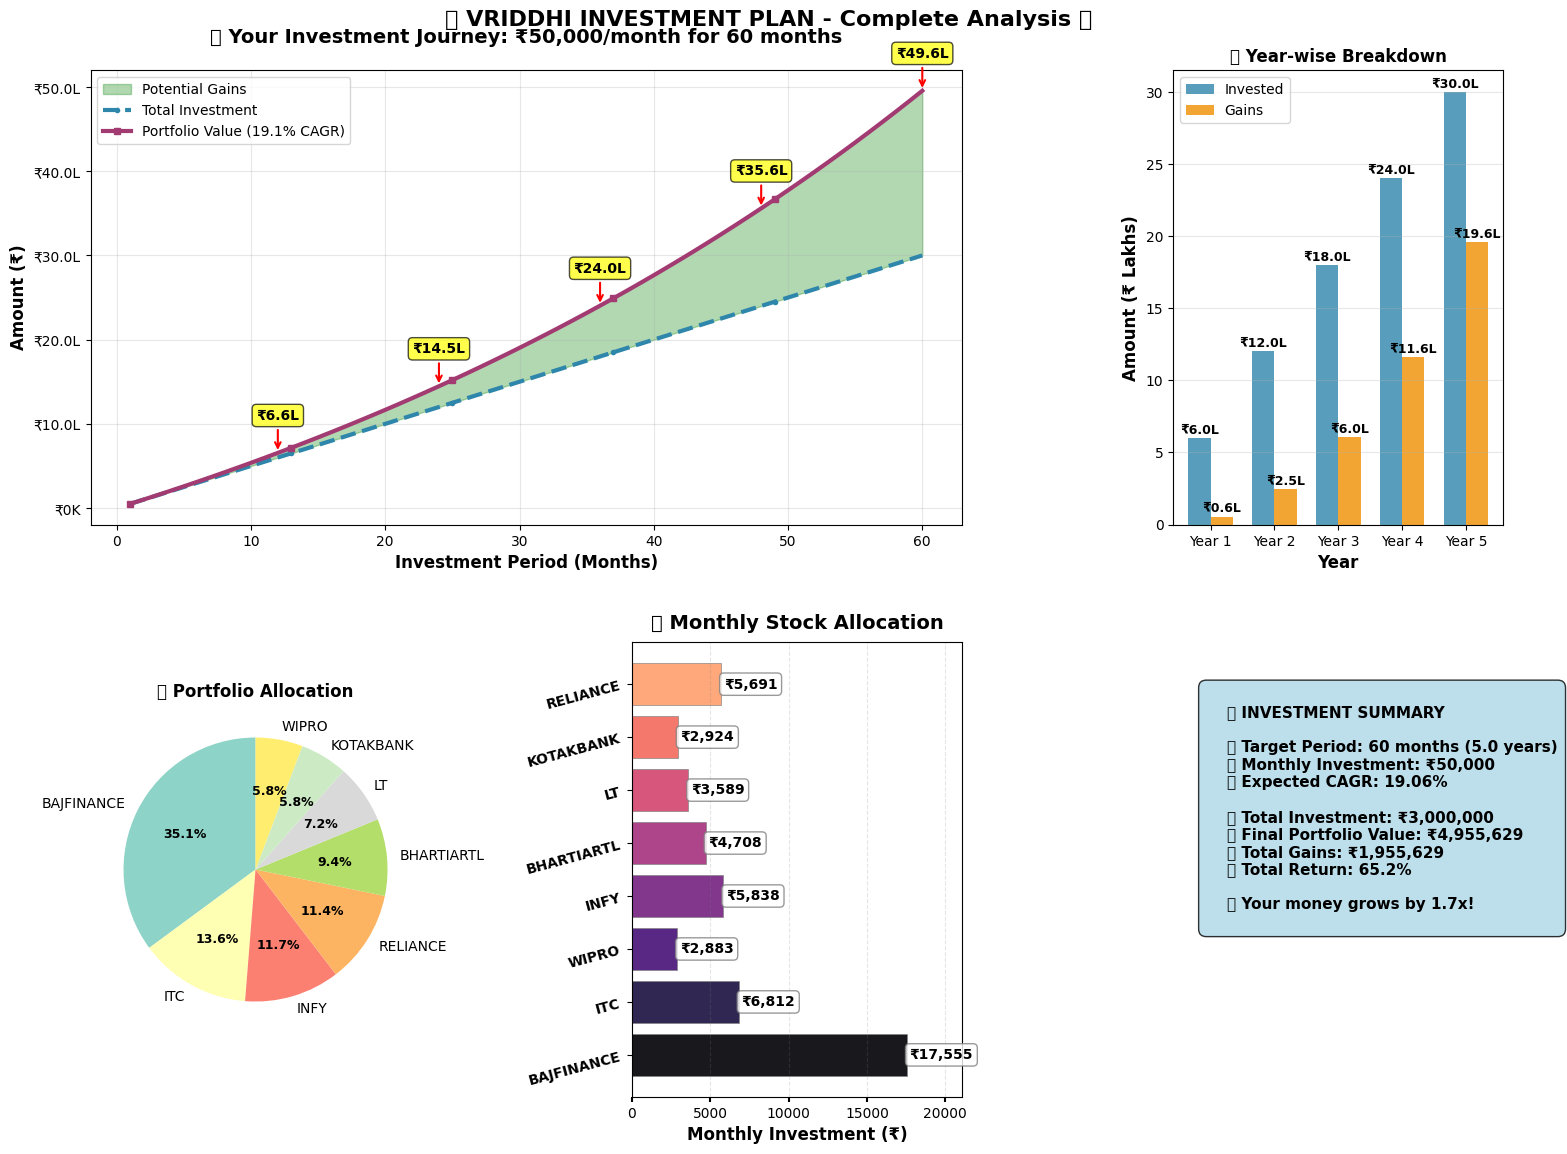

(       Ticker    Weight  Monthly Allocation (INR)
 0  BAJFINANCE  0.351105              17555.233510
 1         ITC  0.136242               6812.112977
 2       WIPRO  0.057666               2883.296126
 3        INFY  0.116758               5837.904875
 4  BHARTIARTL  0.094156               4707.809860
 5          LT  0.071771               3588.544253
 6   KOTAKBANK  0.058479               2923.962792
 7    RELIANCE  0.113823               5691.135606,
 {'Feasible': False,
  'Expected CAGR': 25.0,
  'Achieved CAGR': np.float64(19.0625),
  'Final Value': 4955629,
  'Gain': 1955629})

In [ ]:
run_vriddhi_backend(
    df=df,
    monthly_investment=50000,
    expected_cagr=25.0,  # User's expectation
    horizon_months=60  # Investment horizon
)

In [9]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings

# ===============================
# CONFIGURATION & WARNING SUPPRESSION
# ===============================

# Suppress matplotlib font warnings for emojis in Google Colab
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
warnings.filterwarnings('ignore', category=UserWarning, module='IPython')
warnings.filterwarnings("ignore", category=UserWarning, message="Glyph .* missing from font")

FORECAST_MAP = {
    12: "12M", 18: "18M", 24: "24M", 36: "36M", 48: "48M", 60: "60M",
}

# Set Seaborn style and palette for better visuals
sns.set_style("whitegrid")  # Clean grid style
sns.set_palette("husl", 6)  # Consistent color palette

# ===============================
# 1. STOCK SELECTION MODULE (Enhanced with Sector Diversification)
# ===============================

def get_forecast_column(horizon_months):
    return FORECAST_MAP.get(horizon_months, "60M")

def stock_selector(df, expected_cagr, horizon_months):
    forecast_col = get_forecast_column(horizon_months)

    if 'Volatility' not in df.columns:
        df['Volatility'] = 1 / (df['PE_Ratio'] + 0.1) + (100 - df['Momentum Score']) / 100

    df = df[df['average_cagr'] > 0.14].copy()

    df['PEG'] = df['PE_Ratio'] / (df['average_cagr'] * 100 + 1e-6)
    df['peg_adj_return'] = df[forecast_col] * np.exp(-0.5 * df['PEG'])
    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['PEG', 'peg_adj_return'])

    filtered = df[
        (df["PE_Ratio"] > 0) & (df["PE_Ratio"] <= 40) &
        (df["PB_Ratio"] > 0) & (df["PB_Ratio"] <= 10) &
        (df["Momentum Score"] >= 70) &
        #(df["ROE (%)"] >= 15) &
        (df[forecast_col] >= 0.14)
    ].copy()

    filtered = filtered.dropna(subset=[forecast_col, 'Volatility'])
    filtered = filtered.sort_values(by='peg_adj_return', ascending=False)

    selected_stocks = []
    cumulative_cagr = 0
    count = 0
    sector_counts = defaultdict(int)

    for _, row in filtered.iterrows():
        stock_cagr = row[forecast_col]
        sector = row.get("Sector", "Unknown")
        if sector_counts[sector] >= 2 and count >= 6:
            continue
        cumulative_cagr = ((cumulative_cagr * count) + stock_cagr) / (count + 1)
        selected_stocks.append(row)
        sector_counts[sector] += 1
        count += 1
        if cumulative_cagr >= expected_cagr and count >= 6:
            break

    feasible = cumulative_cagr >= expected_cagr

    if not feasible:
        fallback_stocks = filtered.head(8)
        fallback_cagr = fallback_stocks[forecast_col].mean()
        return fallback_stocks.reset_index(drop=True), False, fallback_cagr
    else:
        selected_df = pd.DataFrame(selected_stocks).reset_index(drop=True)
        return selected_df, True, cumulative_cagr

# ===============================
# 2. OPTIMIZATION MODULE (MPT)
# ===============================

def optimize_portfolio(selected_df, horizon_months):
    forecast_col = get_forecast_column(horizon_months)
    returns = selected_df[forecast_col].values
    risks = selected_df["Volatility"].values
    cov_matrix = np.diag(risks ** 2)

    def objective(weights):
        port_return = np.dot(weights, returns)
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -port_return / port_vol

    n = len(returns)
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = [(0, 1)] * n
    init_guess = np.ones(n) / n

    result = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        selected_df['Weight'] = result.x
    else:
        selected_df['Weight'] = 1.0 / n

    return selected_df

# ===============================
# 3. FINAL PROJECTION & METRICS
# ===============================

def compute_projection(df, monthly_investment, horizon_months, horizon_cagr):
    monthly_cagr = horizon_cagr / 100 / 12
    total_investment = monthly_investment * horizon_months
    if monthly_cagr > 0:
        future_value = monthly_investment * (((1 + monthly_cagr) ** horizon_months - 1) / monthly_cagr)
    else:
        future_value = total_investment
    gain = future_value - total_investment
    return round(total_investment), round(future_value), round(gain)

# ===============================
# 4. ENHANCED VISUALIZATION MODULE
# ===============================

def plot_enhanced_projection(monthly_investment, horizon_months, achieved_cagr, optimized_df=None):
    """
    Creates comprehensive investment visualization with multiple subplots
    """
    fig = plt.figure(figsize=(18, 14))  # Increased figure size for better spacing

    # Calculate projections for the specified horizon
    months = np.arange(1, horizon_months + 1)
    monthly_cagr = achieved_cagr / 100 / 12

    cumulative_invested = monthly_investment * months

    projected_values = []
    for month in months:
        if monthly_cagr > 0:
            fv = monthly_investment * (((1 + monthly_cagr) ** month - 1) / monthly_cagr)
        else:
            fv = monthly_investment * month
        projected_values.append(fv)

    projected_values = np.array(projected_values)
    gains = projected_values - cumulative_invested

    # Subplot 1: Main Investment Growth Chart
    ax1 = plt.subplot(2, 3, (1, 2))
    ax1.fill_between(months, cumulative_invested, projected_values, alpha=0.3, color=sns.color_palette()[0], label='Potential Gains')
    ax1.plot(months, cumulative_invested, '--', linewidth=3, color=sns.color_palette()[1], label='Total Investment', marker='o', markersize=4, markevery=12)
    ax1.plot(months, projected_values, '-', linewidth=3, color=sns.color_palette()[2], label=f'Portfolio Value ({achieved_cagr:.1f}% CAGR)', marker='s', markersize=5, markevery=12)

    key_months = [m for m in [12, 24, 36, 48, 60] if m <= horizon_months]
    for month in key_months:
        idx = month - 1
        ax1.annotate(f'₹{projected_values[idx]/100000:.1f}L', xy=(month, projected_values[idx]),
                     xytext=(month, projected_values[idx] + max(projected_values)*0.05),
                     ha='center', fontsize=12, fontweight='bold', color='darkred',
                     arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                     bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

    ax1.set_xlabel('Investment Period (Months)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Amount (₹)', fontsize=14, fontweight='bold')
    ax1.set_title(f'💰 Your Investment Journey: ₹{monthly_investment:,}/month', fontsize=12, fontweight='bold', pad=15)
    ax1.legend(loc='upper left', fontsize=12, frameon=True, edgecolor='black')
    ax1.grid(True, alpha=0.2, linestyle='--')
    ax1.tick_params(axis='both', labelsize=12, labelcolor='black', width=1.5)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'₹{x/100000:.1f}L' if x >= 100000 else f'₹{x/1000:.0f}K'))

    # Subplot 2: Year-on-Year Growth
    ax2 = plt.subplot(2, 3, 3)
    years = list(range(1, int(horizon_months / 12) + 1))
    year_months = [m for m in [12, 24, 36, 48, 60] if m <= horizon_months]
    year_invested = [cumulative_invested[m-1] for m in year_months]
    year_projected = [projected_values[m-1] for m in year_months]
    year_gains = [year_projected[i] - year_invested[i] for i in range(len(years))]

    x_pos = np.arange(len(years))
    width = 0.35
    bars1 = ax2.bar(x_pos - width/2, [v/100000 for v in year_invested], width, label='Invested', color=sns.color_palette()[3], alpha=0.9)
    bars2 = ax2.bar(x_pos + width/2, [v/100000 for v in year_gains], width, label='Gains', color=sns.color_palette()[4], alpha=0.9)

    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        ax2.text(bar1.get_x() + bar1.get_width()/2., height1 + 0.1, f'₹{height1:.1f}L', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')
        ax2.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.1, f'₹{height2:.1f}L', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

    ax2.set_xlabel('Year', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Amount (₹ Lakhs)', fontsize=14, fontweight='bold')
    ax2.set_title('📈 Year-wise Breakdown', fontsize=14, fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f'Year {y}' for y in years], fontsize=12, fontweight='bold')
    ax2.legend(loc='upper left', fontsize=12, frameon=True)
    ax2.grid(True, alpha=0.2, linestyle='--')

    # Subplot 3: Portfolio Allocation (if provided)
    if optimized_df is not None and len(optimized_df) > 0:
        ax3 = plt.subplot(2, 3, 4)
        top_holdings = optimized_df.nlargest(8, 'Weight')
        others_weight = optimized_df[~optimized_df.index.isin(top_holdings.index)]['Weight'].sum()

        if others_weight > 0:
            plot_data = pd.concat([top_holdings, pd.DataFrame({'Ticker': ['Others'], 'Weight': [others_weight]})], ignore_index=True)
        else:
            plot_data = top_holdings

        wedges, texts, autotexts = ax3.pie(plot_data['Weight'], labels=plot_data['Ticker'], autopct='%1.1f%%',
                                          colors=sns.color_palette()[1:len(plot_data)+1], startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
        ax3.set_title('🎯 Portfolio Allocation', fontsize=14, fontweight='bold', pad=10)

    # Subplot 4: Monthly Investment Breakdown
    ax4 = plt.subplot(2, 3, 5)
    if optimized_df is not None and len(optimized_df) > 0:
        monthly_allocations = optimized_df['Monthly Allocation (INR)'].head(8)
        stock_names = optimized_df['Ticker'].head(8)

        bars = ax4.barh(range(len(monthly_allocations)), monthly_allocations,
                       color=plt.cm.magma(np.linspace(0, 0.8, len(monthly_allocations))),
                       edgecolor='gray', alpha=0.9, linewidth=0.5)

        ax4.set_yticks(range(len(monthly_allocations)))
        ax4.set_yticklabels(stock_names, fontsize=12, fontweight='bold', rotation=15)
        ax4.set_xlabel('Monthly Investment (₹)', fontsize=14, fontweight='bold')
        ax4.set_title('💸 Monthly Stock Allocation', fontsize=16, fontweight='bold', pad=10)

        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax4.text(width + max(monthly_allocations)*0.01, bar.get_y() + bar.get_height()/2,
                    f'₹{width:,.0f}', ha='left', va='center', fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor='gray'))

        ax4.tick_params(axis='x', labelsize=12, labelcolor='black', width=1.5)
        ax4.grid(axis='x', linestyle='--', alpha=0.2, color='gray')
        ax4.set_xlim(0, max(monthly_allocations) * 1.2)

    # Subplot 5: Key Metrics Summary
    ax5 = plt.subplot(2, 3, 6)
    ax5.axis('off')

    final_invested = cumulative_invested[horizon_months-1]
    final_value = projected_values[horizon_months-1]
    total_gain = final_value - final_invested
    gain_percentage = (total_gain / final_invested) * 100

    summary_text = f"""
    📊 INVESTMENT SUMMARY

    🎯 Target Period: {horizon_months} months ({horizon_months/12:.1f} years)
    💰 Monthly Investment: ₹{monthly_investment:,}
    📈 Expected CAGR: {achieved_cagr:.2f}%

    💵 Total Investment: ₹{final_invested:,.0f}
    🚀 Final Portfolio Value: ₹{final_value:,.0f}
    💎 Total Gains: ₹{total_gain:,.0f}
    📊 Total Return: {gain_percentage:.1f}%

    🎉 Your money grows by {final_value/final_invested:.1f}x!
    """

    ax5.text(0.05, 0.9, summary_text, transform=ax5.transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.6", facecolor="#E6F0FA", alpha=0.9),
             fontweight='bold', linespacing=1.5)

    plt.tight_layout(pad=4.0)
    plt.suptitle(f'🌟 VRIDDHI INVESTMENT PLAN - Complete Analysis 🌟', fontsize=14, fontweight='bold', y=0.97)
    plt.show()

# ===============================
# 4. FINAL OUTPUT MODULE (Updated with Frill Integration)
# ===============================

def final_summary_output(feasible: bool, horizon_months: int, expected_cagr: float, achieved_cagr: float, projected_value: float, total_invested: float, best_horizon_60_cagr: float, max_possible_cagr_current_horizon: float, frill_output: dict):
    horizon_years = horizon_months / 12
    gain = projected_value - total_invested

    print("="*80)
    print("🎯 VRIDDHI INVESTMENT ANALYSIS REPORT")
    print("="*80)

    # Display the technical frill output first
    print("🔢 TECHNICAL SUMMARY:")
    print(f"   Feasible: {frill_output['Feasible']}")
    print(f"   Expected CAGR: {frill_output['Expected CAGR']:.2f}%")
    print(f"   Achieved CAGR: {frill_output['Achieved CAGR']:.2f}%")
    print(f"   Final Value: ₹{frill_output['Final Value']:,}")
    print(f"   Total Gain: ₹{frill_output['Gain']:,}\n")

    if feasible:
        print("🎉 SUCCESS: Your investment goals are ACHIEVABLE! 🎉\n")
        print(f"📋 PLAN SUMMARY:")
        print(f"   • Investment Period: {horizon_years:.1f} years ({horizon_months} months)")
        print(f"   • Total Investment: ₹{int(total_invested):,}")
        print(f"   • Expected CAGR: {expected_cagr:.2f}% → Achieved CAGR: {achieved_cagr:.2f}%")
        print(f"   • Final Portfolio Value: ₹{int(projected_value):,}")
        print(f"   • Total Gains: ₹{int(gain):,}")
        print(f"   • Money Multiplier: {projected_value/total_invested:.2f}x\n")

        print("✨ WHAT THIS MEANS FOR YOU:")
        print(f"   Your disciplined investment will grow your wealth by ₹{int(gain):,}")
        print(f"   Every ₹1 you invest will become ₹{projected_value/total_invested:.2f}")
        print("   You're on the path to financial growth! 📈\n")

        print("🎊 CELEBRATION METRICS:")
        print(f"   • You'll be ₹{int(gain):,} richer!")
        print(f"   • That's ₹{int(gain/horizon_months):,} average gain per month!")
        print(f"   • Your wealth will grow {((projected_value/total_invested - 1) * 100):.1f}% over {horizon_years:.1f} years!")

    else:
        print("⚠️  REALITY CHECK: Your expectations need adjustment ⚠️\n")
        print(f"📋 CURRENT SCENARIO:")
        print(f"   • Desired CAGR: {expected_cagr:.2f}%")
        print(f"   • Best Achievable CAGR ({horizon_months} months): {max_possible_cagr_current_horizon:.2f}%")
        print(f"   • Gap: {expected_cagr - max_possible_cagr_current_horizon:.2f}% short\n")

        print("💰 BUT HERE'S THE GOOD NEWS:")
        print(f"   • Even at {achieved_cagr:.2f}% CAGR, you'll still gain ₹{int(gain):,}!")
        print(f"   • Your ₹{int(total_invested):,} will become ₹{int(projected_value):,}")
        print(f"   • That's still a {((projected_value/total_invested - 1) * 100):.1f}% total return!")
        print(f"   • Monthly average gain: ₹{int(gain/horizon_months):,}\n")

        print("💡 SMART RECOMMENDATIONS:")
        print(f"   • Option 1: Accept {max_possible_cagr_current_horizon:.2f}% CAGR → Gain ₹{int(gain):,}")
        print(f"   • Option 2: Extend to 60 months for up to {best_horizon_60_cagr:.2f}% CAGR")
        print(f"   • Option 3: Increase monthly investment to reach your target faster")
        print(f"   • Option 4: Adjust expectations - {achieved_cagr:.2f}% is still excellent!\n")

        print("🧠 PERSPECTIVE CHECK:")
        print(f"   • Bank FD gives ~7% → You're getting {achieved_cagr:.1f}%!")
        print(f"   • Inflation is ~6% → You're beating it by {achieved_cagr - 6:.1f}%!")
        print("   • This is solid wealth creation, even if not your original target!")

    print("="*80)

# ===============================
# 6. WRAPPER FUNCTION (Updated)
# ===============================

def run_vriddhi_backend(df, monthly_investment, expected_cagr, horizon_months):
    print("🚀 Starting Vriddhi Investment Analysis...\n")

    selected_df, feasible, achieved_cagr = stock_selector(df, expected_cagr, horizon_months)
    optimized_df = optimize_portfolio(selected_df, horizon_months)
    optimized_df["Monthly Allocation (INR)"] = optimized_df["Weight"] * monthly_investment

    total_invested, final_value, gain = compute_projection(
        optimized_df, monthly_investment, horizon_months, achieved_cagr
    )

    _, _, best_cagr_60 = stock_selector(df, expected_cagr, 60)

    # Create the frill output dictionary
    frill_output = {
        "Feasible": feasible,
        "Expected CAGR": expected_cagr,
        "Achieved CAGR": achieved_cagr,
        "Final Value": final_value,
        "Gain": gain
    }

    final_summary_output(
        feasible=feasible,
        horizon_months=horizon_months,
        expected_cagr=expected_cagr,
        achieved_cagr=achieved_cagr,
        projected_value=final_value,
        total_invested=total_invested,
        best_horizon_60_cagr=best_cagr_60,
        max_possible_cagr_current_horizon=achieved_cagr,
        frill_output=frill_output
    )

    # Enhanced visualization
    print("\n📊 Generating comprehensive investment visualization...\n")
    plot_enhanced_projection(monthly_investment, horizon_months, achieved_cagr, optimized_df)

    return optimized_df[['Ticker', 'Weight', 'Monthly Allocation (INR)']], frill_output

🚀 Starting Vriddhi Investment Analysis...

🎯 VRIDDHI INVESTMENT ANALYSIS REPORT
🔢 TECHNICAL SUMMARY:
   Feasible: False
   Expected CAGR: 25.00%
   Achieved CAGR: 19.06%
   Final Value: ₹4,955,629
   Total Gain: ₹1,955,629

⚠️  REALITY CHECK: Your expectations need adjustment ⚠️

📋 CURRENT SCENARIO:
   • Desired CAGR: 25.00%
   • Best Achievable CAGR (60 months): 19.06%
   • Gap: 5.94% short

💰 BUT HERE'S THE GOOD NEWS:
   • Even at 19.06% CAGR, you'll still gain ₹1,955,629!
   • Your ₹3,000,000 will become ₹4,955,629
   • That's still a 65.2% total return!
   • Monthly average gain: ₹32,593

💡 SMART RECOMMENDATIONS:
   • Option 1: Accept 19.06% CAGR → Gain ₹1,955,629
   • Option 2: Extend to 60 months for up to 19.06% CAGR
   • Option 3: Increase monthly investment to reach your target faster
   • Option 4: Adjust expectations - 19.06% is still excellent!

🧠 PERSPECTIVE CHECK:
   • Bank FD gives ~7% → You're getting 19.1%!
   • Inflation is ~6% → You're beating it by 13.1%!
   • This 

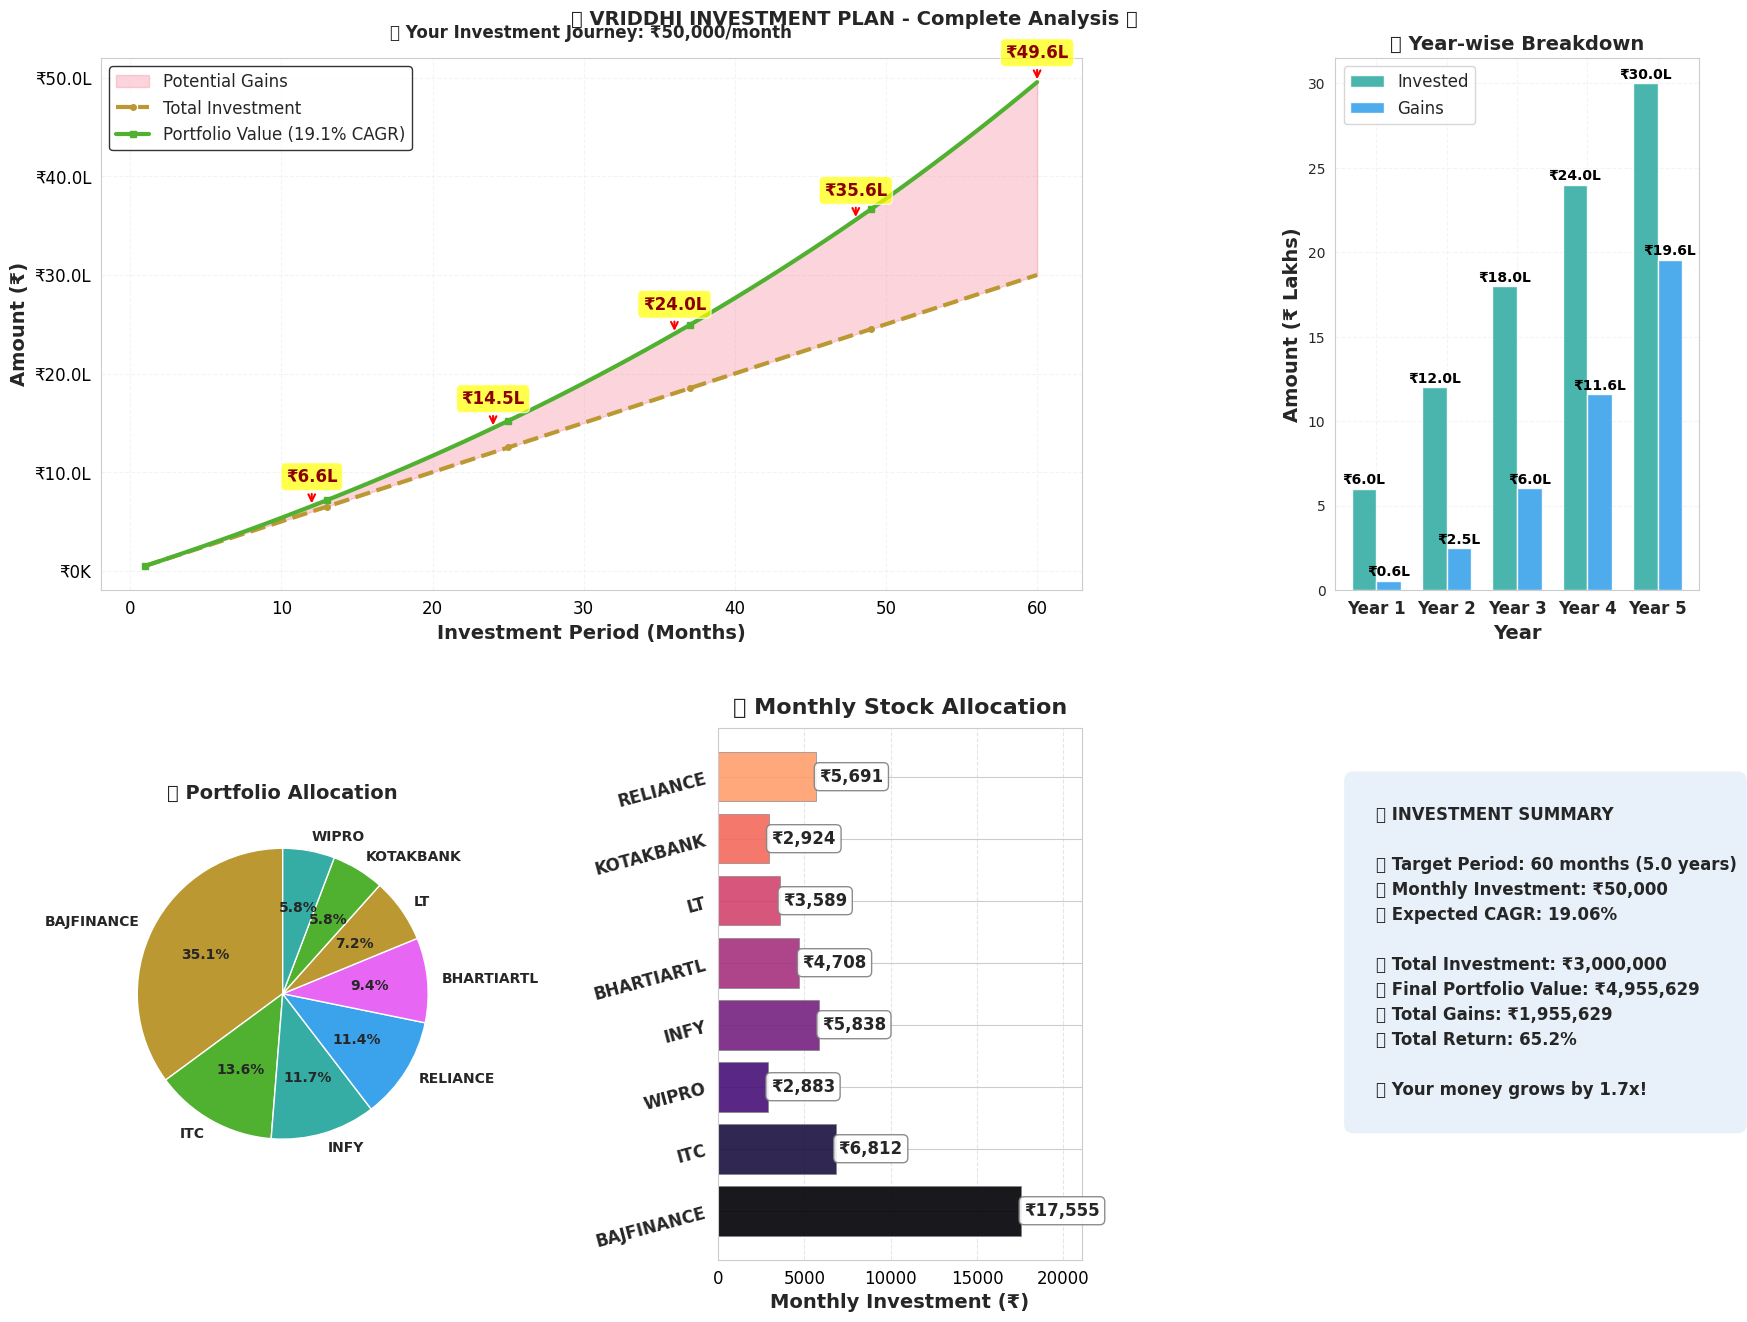

(       Ticker    Weight  Monthly Allocation (INR)
 0  BAJFINANCE  0.351105              17555.233510
 1         ITC  0.136242               6812.112977
 2       WIPRO  0.057666               2883.296126
 3        INFY  0.116758               5837.904875
 4  BHARTIARTL  0.094156               4707.809860
 5          LT  0.071771               3588.544253
 6   KOTAKBANK  0.058479               2923.962792
 7    RELIANCE  0.113823               5691.135606,
 {'Feasible': False,
  'Expected CAGR': 25.0,
  'Achieved CAGR': np.float64(19.0625),
  'Final Value': 4955629,
  'Gain': 1955629})

In [ ]:
run_vriddhi_backend(
    df=df,
    monthly_investment=50000,
    expected_cagr=25.0,  # User's expectation
    horizon_months=60  # Investment horizon
)